# Default Prediction Yelin

In [139]:
# Basic Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing & Pipelines
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# # If not already installed
# pip install category_encoders
# pip install optbinning
import category_encoders as ce
from optbinning import BinningProcess, OptimalBinning
from category_encoders.woe import WOEEncoder

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    recall_score,
    precision_score,
    accuracy_score,
    make_scorer,
    roc_auc_score
)

# Import param_tuning, testing and evaluating
import sys
sys.path.append('D:\Courses for future\Concordia Bootcamp\Projects\Project 5')
from Testing import testing,param_tuning,evaluating,weighted_recall_precision

# Import pretrained model/preprocessor
import joblib

# Set theme
plt.rcParams['axes.grid'] = False
sns.set_theme(style="dark")

## Data at a glance
`risk` dataset was downloaded from [Loan Default Precition](https://www.kaggle.com/datasets/prakashraushan/loan-dataset). There are 12 columns, including `Current_loan_status` as the target column, which has the values of `DEFAULT` and `NO DEFAULT`.   
The remaining 11 columns/features can be divided into 2 categories:
1. Customer Label - `customer_id`, `customer_age`, `customer_income`, `home_ownership`, `employment_duration`, `historical_deafult`, `cred_hist_length`
2. Loan Label - `loan_intent`, `loan_grade`, `loan_int_rate`, `term_years`

In [140]:
risk = pd.read_csv('Loans.csv')
risk.sample(5)

,customer_id,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
17374,17371.0,22,61200,MORTGAGE,6.0,MEDICAL,D,"£16,000.00",16.45,2,N,4,DEFAULT
3116,3115.0,22,18000,RENT,0.0,VENTURE,B,"£3,500.00",13.48,2,Y,2,DEFAULT
31697,31693.0,37,123000,MORTGAGE,1.0,PERSONAL,C,"£35,000.00",14.27,7,Y,16,NO DEFAULT
31289,31285.0,42,85000,MORTGAGE,10.0,HOMEIMPROVEMENT,D,"£8,500.00",15.58,2,Y,12,NO DEFAULT
18305,18302.0,33,47580,RENT,12.0,PERSONAL,B,"£21,000.00",NaN,3,N,8,DEFAULT


In [141]:
# Check dtype
risk.info()
# Missing values
# dtype needs to be corrected: customer_income, loan_amnt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32586 entries, 0 to 32585
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          32583 non-null  float64
 1   customer_age         32586 non-null  int64  
 2   customer_income      32586 non-null  object 
 3   home_ownership       32586 non-null  object 
 4   employment_duration  31691 non-null  float64
 5   loan_intent          32586 non-null  object 
 6   loan_grade           32586 non-null  object 
 7   loan_amnt            32585 non-null  object 
 8   loan_int_rate        29470 non-null  float64
 9   term_years           32586 non-null  int64  
 10  historical_default   11849 non-null  object 
 11  cred_hist_length     32586 non-null  int64  
 12  Current_loan_status  32582 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 3.2+ MB


In [142]:
# Check duplicates
risk.customer_id.nunique() == risk.shape[0] # Contains duplicates

False

In [143]:
# Check missing values
risk.isna().sum()[risk.isna().any()]

customer_id                3
employment_duration      895
loan_amnt                  1
loan_int_rate           3116
historical_default     20737
Current_loan_status        4
dtype: int64

To do:
1. Drop duplicates based on `customer_id`.
2. Drop rows with missing values in either `customer_id` or `loan_amnt` columns
3. Drop `customer_id` column
4. Correct the data types of `customer_income` and `loan_amnt`
5. Encode `DEFAULT` as 1 and `NO DEFAULT` as 0
6. Use rows with missing `Current_loan_status` as `X_pr` for prediction, then drop these rows. 

In [144]:
# Drop duplicates in customer_id
risk_1 = risk.drop_duplicates('customer_id').copy()

# Drop na in customer_id, loan_amnt
risk_1.dropna(subset=['customer_id'],inplace=True)
risk_1.dropna(subset=['loan_amnt'],inplace=True)

# Drop customer_id column
risk_1.drop(columns='customer_id',inplace=True)
risk_1.shape # Pass

# Encode Default = 1, No Default = 0
risk_1.loc[risk_1['Current_loan_status']=='DEFAULT','Current_loan_status_encoded']=1
risk_1.loc[risk_1['Current_loan_status']=='NO DEFAULT','Current_loan_status_encoded']=0

# loan_amnt and customer_income dtype correction
risk_1['loan_amnt'] = pd.to_numeric(risk_1['loan_amnt'].str.replace(',', '').str[1:])
risk_1['customer_income'] = pd.to_numeric(risk_1['customer_income'].str.replace(',',''))
risk_1[['loan_amnt','customer_income']].describe().T # Pass

,count,mean,std,min,25%,50%,75%,max
loan_amnt,32576.0,9724.745211,21071.881794,500.0,5000.0,8000.0,12200.0,3500000.0
customer_income,32576.0,66072.987414,61987.652093,4000.0,38500.0,55000.0,79200.0,6000000.0


In [145]:
# Instances with missing value in Current_loan_status will be used in the end to predict the target.
X_pr = risk_1[risk_1['Current_loan_status'].isna()].drop(columns=['Current_loan_status','Current_loan_status_encoded']).copy()
risk_1.drop(X_pr.index.tolist(),inplace=True) # Pass shape check
X_pr = X_pr.iloc[[0,1,3]].copy() # Drop where loan_int_rate is missing

## Validation and Missing Value Handling

In [146]:
risk_1.Current_loan_status.value_counts(normalize=True) # 0.80 as the baseline AR

Current_loan_status
NO DEFAULT    0.790188
DEFAULT       0.209812
Name: proportion, dtype: float64

### Data Quality Check
##### *`customer_age` cross-check with `employment_duration` and `cred_hist_length`*  
To drop as these entries appear invalid:
1. The age is too small and the customer has worked for an unusually long time (i.e.loc = 29396)
2. The age is unusually high (i.e. loc = 81)


**Note**: For loc = 32427, 32421, 32511 or 32585, these entries appear more valid compared to others, especially when `loan_intent` is *Medical* for three of them. However, since there are only 4 instances, these rows will still be dropped. 

It is noted that `loan_amnt` has the unit of British pounds (£). According to UK law, the minimum working age is 13 with restrictions, and the retirement age is 66 before 2026. Therefore, customers who started working before 13 will be considered as invalid and will be dropped, while those aged 66+ will be pulled out for further review. 

Since in UK, the minimum age to apply for a credit card is 18. Here 17 is chose here to avoid rounding errors. Since there are other possible ways to build credit history before 18, these entries are not considered as invalid and thus are not dropped.

In [147]:
# customer_age, employment_duration cross-validation
risk_1[['customer_age','employment_duration']].describe().T

# There are some issues related to age min==3, max==144, 
# and employment_duration, max==123

,count,mean,std,min,25%,50%,75%,max
customer_age,32572.0,27.732224,6.359996,3.0,23.0,26.0,30.0,144.0
employment_duration,31677.0,4.789563,4.143046,0.0,2.0,4.0,7.0,123.0


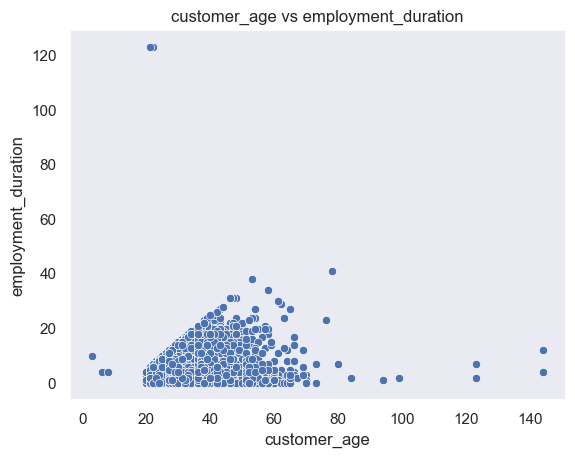

In [148]:
# Visualization to help choose the cut-off
fig1,ax1=plt.subplots()
sns.scatterplot(x=risk_1['customer_age'],y=risk_1['employment_duration'],ax=ax1)
ax1.set_title('customer_age vs employment_duration');

In [149]:
# customer_age<18 or customer_age>80
(risk_1[(risk_1['customer_age']<18) | (risk_1['customer_age']>=80)])
drop_index = (risk_1[(risk_1['customer_age']<18) | (risk_1['customer_age']>=80)].index).tolist() 

# Cross vailidate customer_age with employment_duration
risk_1[(risk_1.customer_age - risk_1.employment_duration)<13] # To drop 
drop_index += (risk_1[(risk_1.customer_age - risk_1.employment_duration)<13]).index.tolist()
len(drop_index)

17

In [150]:
# Dropping
# a. customer_age > 80
# b. customer_age < 18
# c. customer_age - employment_duration <13
len(set(drop_index)) #14
risk_1.drop(set(drop_index),inplace=True)
(risk_1.shape[0] + 14) == 32572 # Pass

True

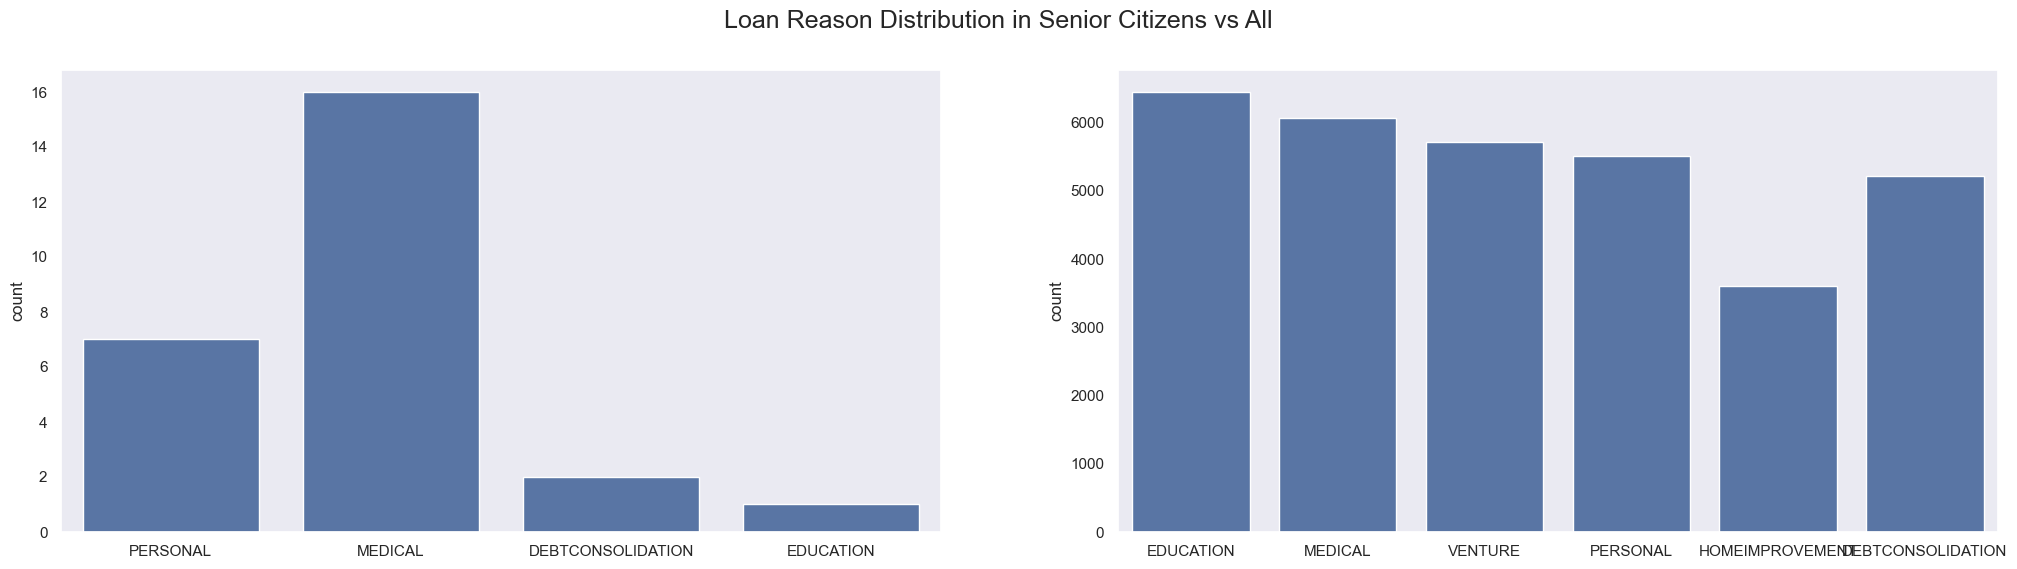

In [151]:
# Visualization, Loan purpose of senior citizens
senior = risk_1[risk_1['customer_age']>=66].copy()

fig2,(ax2,ax3)=plt.subplots(ncols=2,figsize=(25,6))
sns.countplot(data=senior, x='loan_intent',ax=ax2)
ax2.set_xlabel('')

sns.countplot(data=risk_1, x='loan_intent',ax=ax3)
ax3.set_xlabel('')
fig2.suptitle('Loan Reason Distribution in Senior Citizens vs All',fontsize=18);

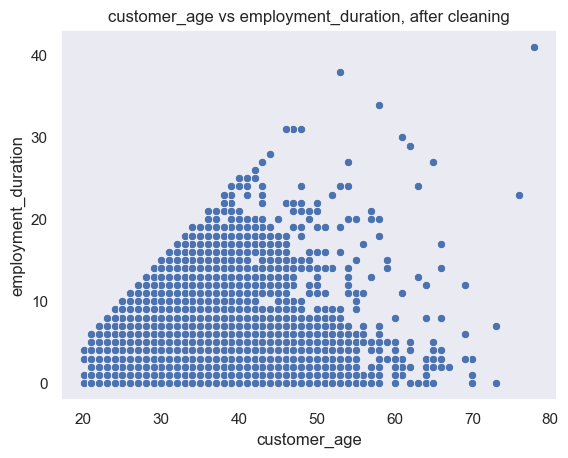

In [152]:
# Visualization after cleaning
fig4,ax4=plt.subplots()
sns.scatterplot(x=risk_1['customer_age'],y=risk_1['employment_duration'],ax=ax4)
ax4.set_title('customer_age vs employment_duration, after cleaning');

In [153]:
# Cross vailidate customer_age with cred_hist_length
risk_1[(risk_1.customer_age - risk_1.cred_hist_length)<17] # 5 instances, considered as valid

,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status,Current_loan_status_encoded
1315,20,64000,RENT,3.0,VENTURE,C,16000.0,15.31,8,Y,4,DEFAULT,1.0
3853,20,32652,MORTGAGE,0.0,PERSONAL,C,6000.0,14.61,2,N,4,DEFAULT,1.0
13920,20,98000,MORTGAGE,4.0,EDUCATION,C,24250.0,NaN,2,NaN,4,NO DEFAULT,0.0
15834,20,188004,MORTGAGE,4.0,EDUCATION,A,2000.0,8.59,2,NaN,4,NO DEFAULT,0.0
17200,20,65000,MORTGAGE,4.0,VENTURE,A,4800.0,9.99,2,NaN,4,NO DEFAULT,0.0


### Handling Missing Values
There are still missing values in `employment_duration` (895, ~3%), `loan_int_rate` (3111, 10%) and `historical_default` (20728, 65%) at this point.

---
**historical_default - fill with "N"**  
There are various reasons why over 20,000 entries have missing values in `historical_default`.

One possible reason is that the customer might not have had any prior loans, leading to the absence of this data. However, a deeper investigation reveals that certain customers with a `home_ownership` status of "Morgage" also have missing values in `historial_default`. This reason might not be the valid reason here.  
 
Additionally, among the non-missing entries, over half of the customers have a historical default. This proportion does not align with the proportion of `Current_loan_status` (where only 20% of the customers have a default status). By replacing the missing values with "N", the proportion of "No Default" would increase to around 0.81, which alighns with the proportion of `Current_loan_status`. Therefore, a bold imputation will be performed: missing values in `historical_default` will be replaced with **"N"**.


---


**loan_int_rate - impute with mean**  
There are different methods to impute missing values in `loan_int_rate`, but simple imputation with sample mean will be used as:
1. There is little to no linear correlation between `loan_int_rate` and related variables, and thus modeling is not a good and efficient method here
2. The difference between mean and median in this feature is small, and the standard deviation relatively okay.. Well..
3. WOE could have been applied here to assign all missing value with a specific value. This method, will however, be explored when filling in `employment_duration`

---
**employment_duration - drop missing values or handle with WOE encoder**  
There are also various methods to impute missing values in `employment_duration`. Here, **dropping all missing entries** and/or **WOE encoding** will be used to compare the final model to compare the effect different choices of handling missing values on the built model. Simple imputation is not used because the standard deviation is high compared with its mean. Modeling is not preferred also because there is little to no correaltion between this feature and other related features. 

**See more on [Weight of Evidence Encoding](https://ishanjainoffical.medium.com/understanding-weight-of-evidence-woe-with-python-code-cd0df0e4001e) and [Optimal Binning](http://gnpalencia.org/optbinning/tutorials/tutorial_binary.html).**

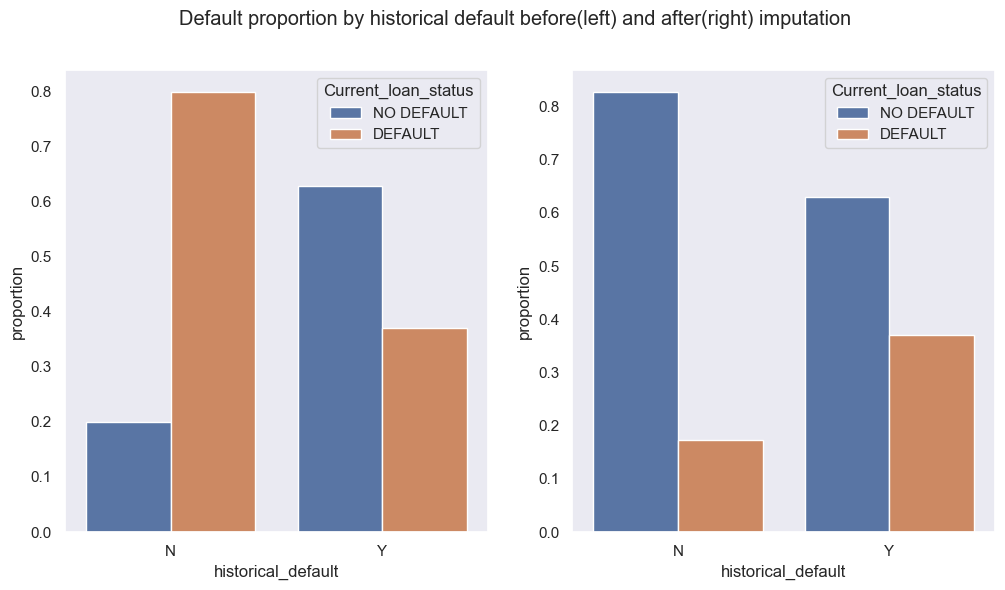

In [154]:
# historical default - replace with N
risk_1.historical_default.value_counts(normalize=True).reset_index() # 0.48 N
sum_before = (risk_1.groupby('historical_default',as_index=False)['Current_loan_status'].value_counts(normalize=True))
risk_1.fillna({'historical_default':'N'},inplace=True) # Replace with N
risk_1.historical_default.value_counts(normalize=True).reset_index() # N = 0.81, current_N = 0.79
sum_after = (risk_1.groupby('historical_default',as_index=False)['Current_loan_status'].value_counts(normalize=True))

# Visualization, before imputation vs after imputation
fig5,(ax5,ax6) = plt.subplots(ncols=2, figsize=(12,6))
sns.barplot(data=sum_before.sort_values(by=['historical_default','Current_loan_status'],ascending=[True,False]), 
            x='historical_default', y='proportion', hue='Current_loan_status',ax=ax5)

sns.barplot(data=sum_after, 
            x='historical_default', y='proportion', hue='Current_loan_status',ax=ax6)
plt.suptitle('Default proportion by historical default before(left) and after(right) imputation');

In [155]:
# loan_int_rate - impute with mean
risk_1[['loan_int_rate','customer_income','loan_amnt','term_years']].corr() # Little to no correlation
risk_1[['loan_int_rate']].describe().T

risk_nna = risk_1.copy()
risk_nna['loan_int_rate']=risk_nna['loan_int_rate'].fillna(risk_1['loan_int_rate'].mean())

In [156]:
# Drop Missing values in employment_duration
risk_1[['employment_duration']].describe().T
risk_1[['employment_duration','cred_hist_length','customer_age','customer_income']].corr() # Little correlation, which is odd but acceptable

risk_nna = risk_nna.dropna(subset=['employment_duration'])
risk_nna.isna().sum() # Pass no missing values

risk_nna.reset_index(inplace=True)

## Univariate Analysis/EDA
For numeric columns, the **Gini coefficient** will be used instead of **Pearson correlation** to compare the relationship between the feature and the target. The two correlation will be compared later to show that the features are not linearly related to the target. 

**More on [Gini Coefficient](https://www.google.com/search?sca_esv=696f62cce5599e91&sca_upv=1&q=gini+coefficient&tbm=vid&source=lnms&fbs=AEQNm0DPvcmG_nCbmwtBO9j6YBzM68ZanC7g01Skprhw5JoufUv28nkH7BlZuPSVPZEeFf4zEsryEwMB77hXASo0GX6kc7f0ImceuC_sjza6Vb-covmbyhpamE8nFdDBXPVPzJTQU7MBXAFnfR130LMIBhqrIsoOl8ieFfXS3GWSgLtJxTcf267Wv5rKKgyx7fFUGn8sBvvl1n7GOk6qRIkbzjH9GOGG3A&sa=X&ved=2ahUKEwjtmsbu2-2HAxWBFlkFHR9-ECUQ0pQJegQIEhAB&biw=2560&bih=1321#fpstate=ive&vld=cid:a026287b,vid:BwSB__Ugo1s,st:0)**

For categorical columns, visualizations will be created to show the proportion of DEFAULT and NO DEFAULT in different categories to reveal the patterns. Since the visualization is not pretty, it will be commented out....

In [157]:
target = ['Current_loan_status_encoded']
cat_col = ['home_ownership','loan_intent', 'loan_grade','historical_default']
num_col = ['customer_age','customer_income','employment_duration','loan_amnt','loan_int_rate','term_years','cred_hist_length']

In [158]:
# Establish Gini Coefficient
target_df = risk_nna['Current_loan_status']
gini = []
name = []
for columns in num_col:
    feature = risk_nna[f'{columns}']
    auc = roc_auc_score(target_df, feature)
    gini_coefficient = 2 * auc - 1# Conversion from auc to gini
    name.append(f'{columns}')
    gini.append(gini_coefficient)
corr_gini_df = pd.DataFrame({'name':name, 'gini':gini} )
corr_gini_df.sort_values(by = 'gini', ascending=False)

,name,gini
1,customer_income,0.365103
2,employment_duration,0.140473
0,customer_age,0.047529
6,cred_hist_length,0.034789
5,term_years,-0.040078
3,loan_amnt,-0.118115
4,loan_int_rate,-0.432170


Note that `loan_int_rate` seems to have the highest correlation with the target. However, this is also a variable with moderate imputation (10% of the data is missing). Therefore, it is important to check if the imputation has disturbed its original pattern.

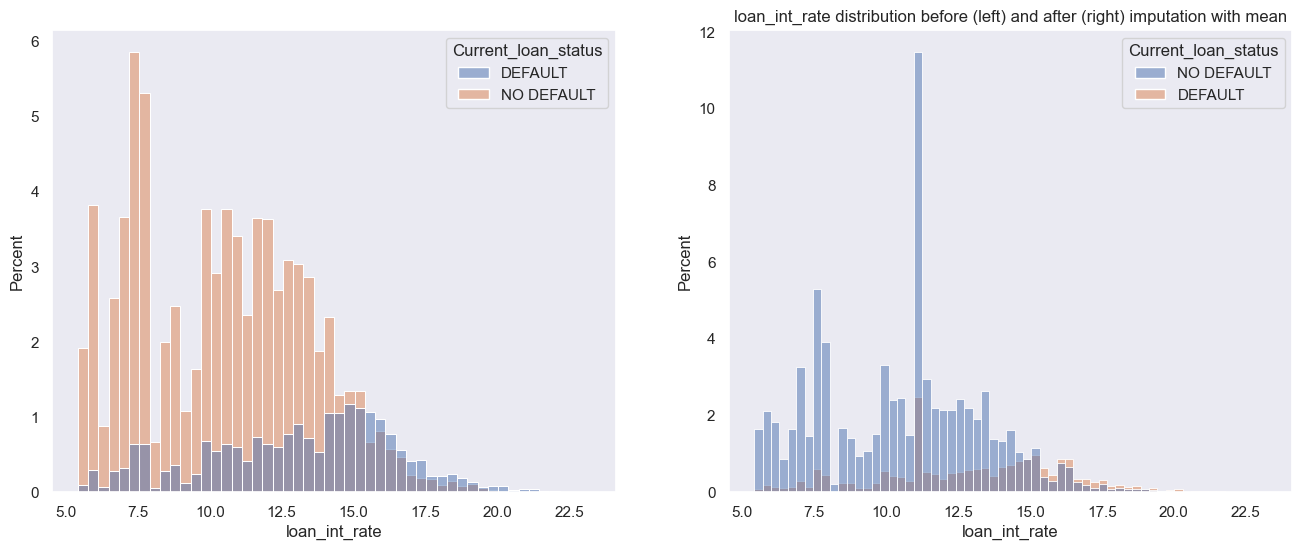

In [159]:
figd, (axd,axe) = plt.subplots(ncols=2,figsize=(16,6))
sns.histplot(data=risk, x='loan_int_rate', hue='Current_loan_status',stat='percent',ax=axd)
sns.histplot(data=risk_nna, x='loan_int_rate', hue='Current_loan_status',stat='percent',ax=axe)
plt.title('loan_int_rate distribution before (left) and after (right) imputation with mean');

# It has disturbed the distribution a liitle bit.. as there are noticeably more defaults when interest rate is around 11...
# Maybe in this case WOE is better? Sadly, due to the time restrain, this will not be explored.

In [160]:
def cat_visual(df, col, ax):
    '''
    This function aims to visualize the proportion of Default vs No Default in different categories of a chosen column

    :param [df]: dataframe of interest
    :type [df]: pd.DataFrame

    :param [col]: columnn name of interest
    :type [col]: str

    :param [ax]: the axis to be plotted on
    :type [ax]: matplotlib.axe.Axes
    ...
    :return: the summary of DEFAULT proportion grouped by selected column
    :rtype: pd.DataFrame
    
    '''
    summary = (df.groupby(col,as_index=False)['Current_loan_status'].value_counts(normalize=True))

    sns.barplot(data=summary, x=col, y='proportion', hue='Current_loan_status',ax=ax)
    ax.set_title(f'Current Loan Status Percentage by {col}')
    ax.set_ylabel('Proportion')

    return summary

In [161]:
# # Visualization
# # Excuse me for the bad viz here, partially because of the long name of debt intent
# # To fix this, loan intent can be coded with letters for example, and creation of another dataset to be able to refer back the loan intent is needed.

# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(22,22))
# ax1a, ax2a, ax3a, ax4a = axs.flatten()
# sum_1 = cat_visual(risk_nna,'home_ownership',ax=ax1a)
# sum_2 = cat_visual(risk_nna,'loan_intent',ax=ax2a)
# sum_3 = cat_visual(risk_nna,'loan_grade',ax=ax3a)
# sum_4 = cat_visual(risk_nna,'historical_default',ax=ax4a)

## Train Test Split and WOE Encoding
WOE encoding will be applied to all the columns in the dataset that contain missing values in `employment_duration`. This is probably not the best way to compare the effect of WOE encoding on handling missing values. A better approach might be to encode only `employment_duration`. Sadly, let's keep it as it is for this project.

In [162]:
# Train test split before WOE encoding

# With No missing value
# Recall:
# historical_default was filled with N
# loan_int_rate was imputed by mean
# employment_duration was dropped
X_nna = risk_nna[cat_col+num_col]
y_nna = risk_nna[target[0]]
X_train_nna, X_test_nna, y_train_nna, y_test_nna = train_test_split(X_nna, y_nna, test_size=0.1, 
                                                                    stratify=risk_nna['loan_intent'], 
                                                                    random_state=5000, shuffle=True)


# With missing values
# Recall:
# historical_default was filled with N
# loan_int_rate was imputed by mean
# employment_duration was not dropped, will be handling with WOE
X_na = risk_1[cat_col+num_col]
y_na = risk_1[target[0]]
X_train_na, X_test_na, y_train_na, y_test_na = train_test_split(X_na, y_na, test_size=0.1, 
                                                                    stratify=risk_1['loan_intent'], 
                                                                    random_state=5000, shuffle=True)

In [163]:
# WOE encoding
woe_table_na = {}
for col in num_col:
    optb = OptimalBinning(name=col,dtype='numerical')
    optb.fit(X_train_na[col], y_train_na)
    X_train_na[f'{col}_woe'] =  optb.transform(X_train_na[col], metric="woe")
    X_test_na[f'{col}_woe'] = optb.transform(X_test_na[col])
    woe_table_na[col] = optb.binning_table


for col in cat_col:
    optb = OptimalBinning(name=col,dtype='categorical')
    optb.fit(X_train_na[col], y_train_na)
    X_train_na[f'{col}_woe'] =  optb.transform(X_train_na[col], metric="woe")
    X_test_na[f'{col}_woe'] = optb.transform(X_test_na[col])
    woe_table_na[col] = optb.binning_table

# Pull WOE table Example
woe_table_na['employment_duration'].build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",6318,0.215617,4624,1694,0.268123,-0.326614,0.025170,0.003132
1,"[1.50, 2.50)",3455,0.117910,2587,868,0.251230,-0.238719,0.007184,0.000896
2,"[2.50, 4.50)",5663,0.193263,4534,1129,0.199364,0.059491,0.000672,0.000084
3,"[4.50, 5.50)",2654,0.090574,2173,481,0.181236,0.177215,0.002698,0.000337
4,"[5.50, 6.50)",2385,0.081394,1967,418,0.175262,0.218002,0.003624,0.000452
5,"[6.50, 7.50)",1960,0.066890,1619,341,0.173980,0.2269,0.003217,0.000401
6,"[7.50, 11.50)",4088,0.139513,3412,676,0.165362,0.288079,0.010615,0.001322
7,"[11.50, inf)",1968,0.067163,1680,288,0.146341,0.432807,0.011022,0.001367
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,811,0.027677,581,230,0.283600,-0.40411,0.005045,0.000626


To be honest, the grouping established here might not be the best. For example, groups of [5.50, 6.50) and [6.50, 7.50) have value similar values after encoding.

In [164]:
# Establish WOE dataframe
X_train_woe = X_train_na.drop(columns=cat_col+num_col).copy()
X_test_woe = X_test_na.drop(columns=cat_col+num_col).copy()
X_train_woe.sample(5)

,customer_age_woe,customer_income_woe,employment_duration_woe,loan_amnt_woe,loan_int_rate_woe,term_years_woe,cred_hist_length_woe,home_ownership_woe,loan_intent_woe,loan_grade_woe,historical_default_woe
9467,0.013556,0.413595,0.226900,-0.019094,0.833653,0.193476,-0.028593,0.701188,0.497521,0.882045,0.239359
20156,0.023818,-0.802463,0.177215,0.079598,1.362785,0.193476,0.046302,-0.523539,-0.224340,0.882045,0.239359
1075,0.013556,0.413595,-0.326614,-0.260599,-1.764208,-0.517952,-0.028593,-0.523539,-0.224340,-1.734666,-0.788629
31762,0.147604,1.117634,-0.326614,0.114179,-0.375637,0.161363,0.121615,0.701188,0.497521,-0.755771,0.239359
13958,0.023818,0.413595,-0.238719,-0.019094,0.160378,0.161363,-0.028593,-0.523539,-0.224340,0.882045,0.239359


## Baseline Model 
Use `loan_grade`, `customer_income`, and `loan_int_rate`. RMF and KNN are used to estbalish a baseline model as a reference.

In [165]:
# Define numeric & categorical col
# not woe encoded
numeric_col_nna_bsl = ['customer_income','loan_int_rate']
categorical_col_nna_bsl = ['loan_grade']

X_train_nna_bsl = X_train_nna[categorical_col_nna_bsl+numeric_col_nna_bsl]
X_test_nna_bsl = X_test_nna[categorical_col_nna_bsl+numeric_col_nna_bsl]
# woe encoded
numeric_col_woe_bsl = ['loan_grade_woe','customer_income_woe','loan_int_rate_woe']
categorical_col_woe_bsl = []

X_train_woe_bsl = X_train_woe[categorical_col_woe_bsl+numeric_col_woe_bsl]
X_test_woe_bsl = X_test_woe[categorical_col_woe_bsl+numeric_col_woe_bsl]

### Random Forest
Running param_search will take 4.5mins. To save time, the preprocessor was dumped and reloaded. 

In [166]:
# # Define grid search parameters
# # With no missing
param_grid_rmf = {
    'classifier__n_estimators':[50,100,150,200],
    'classifier__max_features':[None,'sqrt'],
}

# # Tuning
# preprocessor_rmf_nna_bsl = param_tuning(X_train_nna_bsl,y_train_nna, RandomForestClassifier(),param_grid_rmf,cat_col=categorical_col_nna_bsl,num_col=numeric_col_nna_bsl)

# # With WOE
# # Tuning
# preprocessor_rmf_woe_bsl = param_tuning(X_train_woe_bsl,y_train_na, RandomForestClassifier(),param_grid_rmf,cat_col=categorical_col_woe_bsl,num_col=numeric_col_woe_bsl)

# joblib.dump(preprocessor_rmf_nna_bsl,'preprocessor_rmf_nna_bsl.pkl')
# joblib.dump(preprocessor_rmf_woe_bsl,'preprocessor_rmf_woe_bsl.pkl')

In [167]:
preprocessor_rmf_nna_bsl = joblib.load('preprocessor_rmf_nna_bsl.pkl')
preprocessor_rmf_woe_bsl = joblib.load('preprocessor_rmf_woe_bsl.pkl')

In [168]:
# Training & testing
# With no missing
model_rmf_nna_bsl = RandomForestClassifier(
                        max_features=None, 
                        n_estimators = 100,
                                        )
y_pred_rmf_nna_bsl = testing(X_train_nna_bsl,y_train_nna, X_test_nna_bsl,y_test_nna, model=model_rmf_nna_bsl, preprocessor=preprocessor_rmf_nna_bsl)

# With WOE
model_rmf_woe_bsl = RandomForestClassifier(
                        max_features=None, 
                        n_estimators = 150,
                                        )
y_pred_rmf_woe_bsl = testing(X_train_woe_bsl,y_train_na, X_test_woe_bsl,y_test_na, model=model_rmf_woe_bsl, preprocessor=preprocessor_rmf_woe_bsl)

Random Forest Classifier bsl Evaluation


<Figure size 800x600 with 0 Axes>

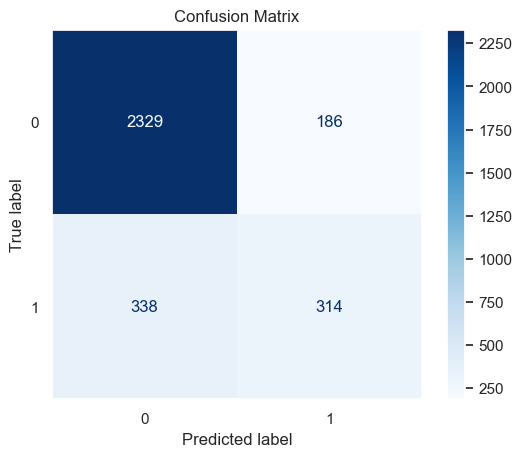

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      2515
         1.0       0.63      0.48      0.55       652

    accuracy                           0.83      3167
   macro avg       0.75      0.70      0.72      3167
weighted avg       0.82      0.83      0.83      3167

******************************************************************************************************************************************************
Random Forest Classifier bsl Evaluation, woe


<Figure size 800x600 with 0 Axes>

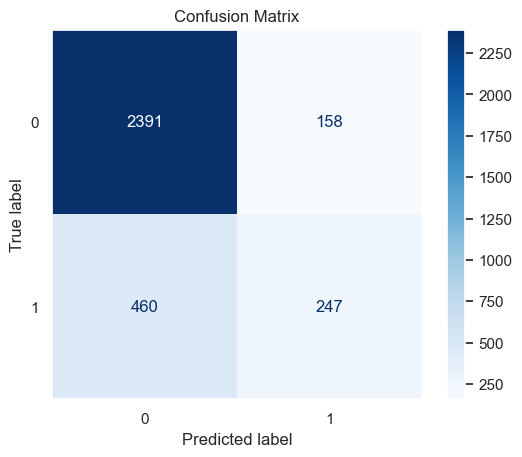

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89      2549
         1.0       0.61      0.35      0.44       707

    accuracy                           0.81      3256
   macro avg       0.72      0.64      0.66      3256
weighted avg       0.79      0.81      0.79      3256



In [169]:
# Evaluating
print('Random Forest Classifier bsl Evaluation')
evaluating(y_pred_rmf_nna_bsl,y_test_nna) 


print('*'*150)
print('Random Forest Classifier bsl Evaluation, woe')
evaluating(y_pred_rmf_woe_bsl,y_test_na) 

### KNN
Takes around 1 min

In [170]:
# Define grid search parameters 6mins
param_grid_knn = {
    'classifier__n_neighbors':[5,15,20,30,50],
    'classifier__weights':['uniform','distance'],
}
# Tuning
preprocessor_knn_nna_bsl = param_tuning(X_train_nna_bsl,y_train_nna, KNeighborsClassifier(),param_grid_knn,cat_col=categorical_col_nna_bsl,num_col=numeric_col_nna_bsl)

# With WOE
# Tuning
preprocessor_knn_woe_bsl = param_tuning(X_train_woe_bsl,y_train_na, KNeighborsClassifier(),param_grid_knn,cat_col=categorical_col_woe_bsl,num_col=numeric_col_woe_bsl)

Best parameters found:  {'classifier__n_neighbors': 50, 'classifier__weights': 'distance'}
Best parameters found:  {'classifier__n_neighbors': 50, 'classifier__weights': 'uniform'}


In [171]:
# Training & testing
# With no missing
model_knn_nna_bsl = KNeighborsClassifier(
                        n_neighbors=50, 
                        weights = 'distance',
                                        )
y_pred_knn_nna_bsl = testing(X_train_nna_bsl,y_train_nna, X_test_nna_bsl,y_test_nna, model=model_knn_nna_bsl, preprocessor=preprocessor_knn_nna_bsl)

# With WOE
model_knn_woe_bsl = KNeighborsClassifier(
                        n_neighbors=50, 
                        weights = 'uniform',
                                        )
y_pred_knn_woe_bsl = testing(X_train_woe_bsl,y_train_na, X_test_woe_bsl,y_test_na, model=model_knn_woe_bsl, preprocessor=preprocessor_knn_woe_bsl)

KNN Model bsl Evaluation


<Figure size 800x600 with 0 Axes>

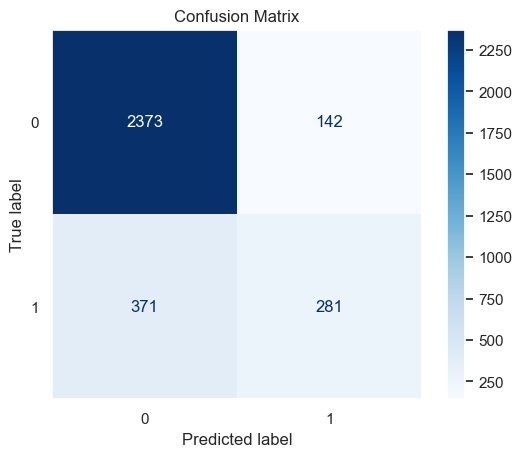

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      2515
         1.0       0.66      0.43      0.52       652

    accuracy                           0.84      3167
   macro avg       0.76      0.69      0.71      3167
weighted avg       0.82      0.84      0.82      3167

******************************************************************************************************************************************************
KNN Model bsl Evaluation, woe


<Figure size 800x600 with 0 Axes>

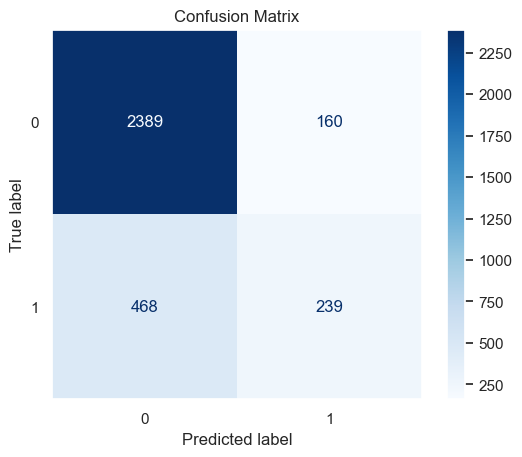

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88      2549
         1.0       0.60      0.34      0.43       707

    accuracy                           0.81      3256
   macro avg       0.72      0.64      0.66      3256
weighted avg       0.78      0.81      0.79      3256



In [172]:
# Evaluating - worse
print('KNN Model bsl Evaluation')
evaluating(y_pred_knn_nna_bsl,y_test_nna) 


print('*'*150)
print('KNN Model bsl Evaluation, woe')
evaluating(y_pred_knn_woe_bsl,y_test_na) 

**Insight**:
1. Incorporating the missing values using WOE seems to have increased the difficulty or noise in predicting the target. 
2. By using these three features, the model's performance is acceptable, but it produces a significant number of false negatives, indicating a preference for predicting negative values. This is partly due to the imbalance in the target proportion. Because of that, the RMF that incoperate all features will be established below to show the potential maximum performance. 

## RMF with all features
Tuning takes around 6mins, the preprocessor will be dumped and reused to save time. 

After generation of this RMF model, feature importance was pulled out to facilitate feature selection. 

In [173]:
numeric_col_nna_all = num_col.copy()
categorical_col_nna_all = cat_col.copy()

X_train_nna_all = X_train_nna[categorical_col_nna_all+numeric_col_nna_all]
X_test_nna_all = X_test_nna[categorical_col_nna_all+numeric_col_nna_all]

In [174]:
# # Tuning
# preprocessor_rmf_nna_all = param_tuning(X_train_nna_all,y_train_nna, 
#                                         RandomForestClassifier(),param_grid_rmf,
#                                         cat_col=categorical_col_nna_all,num_col=numeric_col_nna_all)
# joblib.dump(preprocessor_rmf_nna_all,'preprocessor_rmf_nna_all.pkl')

In [175]:
# Training & testing
preprocessor_rmf_nna_all = joblib.load('preprocessor_rmf_nna_all.pkl')
model_rmf_nna_all = RandomForestClassifier(
                        max_features=None, 
                        n_estimators = 100,
                                        )
y_pred_rmf_nna_all = testing(X_train_nna_all,y_train_nna, X_test_nna_all,y_test_nna, model=model_rmf_nna_all, preprocessor=preprocessor_rmf_nna_all)

Random Forest Model with ALL Features Evaluation, all


<Figure size 800x600 with 0 Axes>

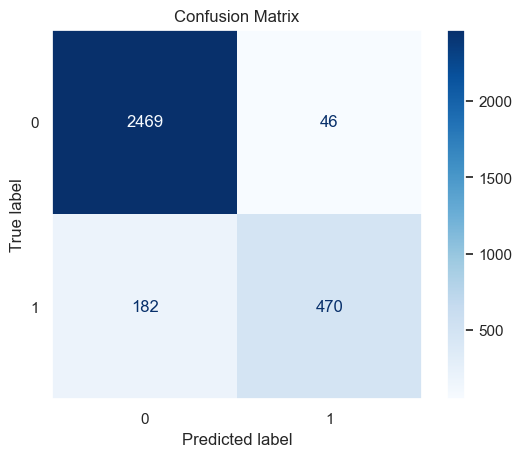

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      2515
         1.0       0.91      0.72      0.80       652

    accuracy                           0.93      3167
   macro avg       0.92      0.85      0.88      3167
weighted avg       0.93      0.93      0.92      3167



In [176]:
print('Random Forest Model with ALL Features Evaluation, all')
evaluating(y_pred_rmf_nna_all, y_test_nna) 

By accident, in one test run, missing values in `historical_default` were not replaced by "N", and `historical_default_NaN` ended up with the highest feature importance, boosting the accuracy ratio to 0.97 and recall to 0.90. This suggests that the bold decision was indeed bold but not good.. The choice of handling the missing value will change the model performance somtimes, especially when the percentage of the missing values is big (in this case, it is 65%).   
This has been noted, but the following analysis will be based on the original method as it is already 5pm on Sunday. 

In [177]:
# Pulling feature importance
preprocessor = preprocessor_rmf_nna_all
cat_names = list(preprocessor.transformers_[0][1].named_steps['encoder'].get_feature_names_out(cat_col))
num_names = list(preprocessor.transformers_[1][1].named_steps['scaler'].get_feature_names_out(num_col))
feature_names = cat_names + num_names

importance_df = pd.DataFrame({'names':feature_names, 'importance':list(model_rmf_nna_all.feature_importances_)})
importance_df.sort_values(by='importance',ascending=False)

,names,importance
14,customer_income,0.233182
17,loan_int_rate,0.194895
16,loan_amnt,0.150208
2,home_ownership_RENT,0.079165
15,employment_duration,0.062579
13,customer_age,0.051542
19,cred_hist_length,0.038027
18,term_years,0.027501
4,loan_intent_HOMEIMPROVEMENT,0.025461
5,loan_intent_MEDICAL,0.025298


It is noted that `customer_income`, `loan_int_rate`, `loan_amnt` and `employment_duration` have greatest feature importance. At the same time the gini coefficient is high. Therefore, these four features will be included in the future models. `loan_grade` as less predictive power than expected, and thus it will be removed from the model. `homw_ownership` and `loan_intent` will be included in the future models.

## Model 2 - with 6 features

In [178]:
# Define numeric & categorical col
numeric_col_nna_2 = ['customer_income','loan_int_rate','employment_duration','loan_amnt']
categorical_col_nna_2 = ['loan_intent','home_ownership']

X_train_nna_2 = X_train_nna[categorical_col_nna_2+numeric_col_nna_2]
X_test_nna_2 = X_test_nna[categorical_col_nna_2+numeric_col_nna_2]

### Random Forest Regression
Tuning takes around 5mins, the preprocessor will be dumped and reloaded. 

In [179]:
# # Tuning
# preprocessor_rmf_nna_2 = param_tuning(X_train_nna_2,y_train_nna, 
#                                         RandomForestClassifier(),param_grid_rmf,
#                                         cat_col=categorical_col_nna_2,num_col=numeric_col_nna_2)
# joblib.dump(preprocessor_rmf_nna_2,'preprocessor_rmf_nna_2.pkl')

In [180]:
# Training & testing
preprocessor_rmf_nna_2 = joblib.load('preprocessor_rmf_nna_2.pkl')
model_rmf_nna_2 = RandomForestClassifier(
                        max_features=None, 
                        n_estimators = 150,
                                        )
y_pred_rmf_nna_2 = testing(X_train_nna_2,y_train_nna, X_test_nna_2,y_test_nna, model=model_rmf_nna_2, preprocessor=preprocessor_rmf_nna_2)

Random Forest Model 2 Evaluation


<Figure size 800x600 with 0 Axes>

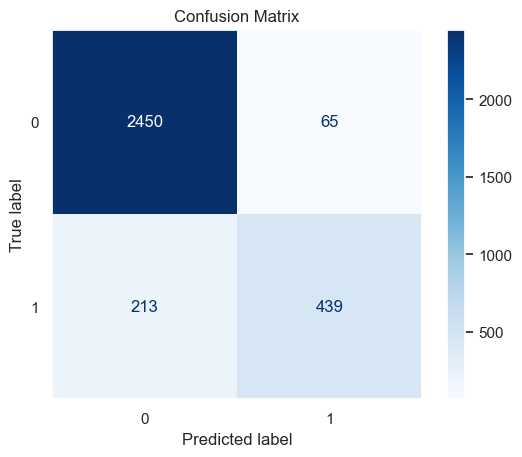

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95      2515
         1.0       0.87      0.67      0.76       652

    accuracy                           0.91      3167
   macro avg       0.90      0.82      0.85      3167
weighted avg       0.91      0.91      0.91      3167



In [181]:
print('Random Forest Model 2 Evaluation')
evaluating(y_pred_rmf_nna_2,y_test_nna) 

### KNN

In [182]:
# Tuning
preprocessor_knn_nna_2 = param_tuning(X_train_nna_2,y_train_nna, KNeighborsClassifier(),param_grid_knn,cat_col=categorical_col_nna_2,num_col=numeric_col_nna_2)

Best parameters found:  {'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}


In [183]:
# Training & testing
# With no missing
model_knn_nna_2 = KNeighborsClassifier(
                        n_neighbors=15, 
                        weights = 'distance',
                                        )
y_pred_knn_nna_2 = testing(X_train_nna_2,y_train_nna, X_test_nna_2,y_test_nna, model=model_knn_nna_2, preprocessor=preprocessor_knn_nna_2)

KNN Model 2 Evaluation


<Figure size 800x600 with 0 Axes>

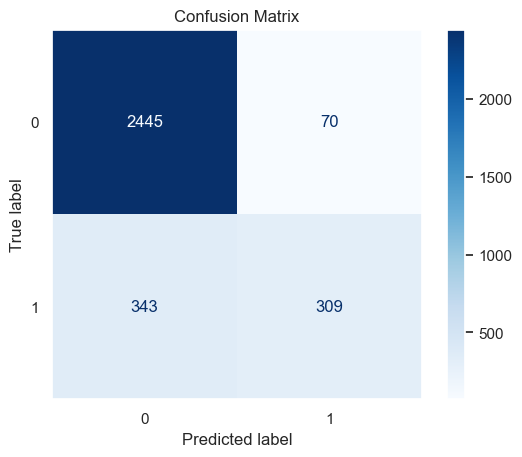

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92      2515
         1.0       0.82      0.47      0.60       652

    accuracy                           0.87      3167
   macro avg       0.85      0.72      0.76      3167
weighted avg       0.86      0.87      0.86      3167



In [184]:
print('KNN Model 2 Evaluation')
evaluating(y_pred_knn_nna_2,y_test_nna)  

## Final Model
Random Forest Classifier with `customer_income`,`loan_int_rate`,`employment_duration`,`loan_amnt`, `loan_intent` and `home_ownership` is chosen as the final model as it gives the best performance with fewer features. Maybe Random Forest Classifier with all features should be chosen as there are not many features anyways, but it is what it is.

In [185]:
# # Export preprocessor 
# joblib.dump(preprocessor_rmf_nna_2,'preprocessor_final.pkl')

In [186]:
numeric_col_f = ['customer_income','loan_int_rate','employment_duration','loan_amnt']
categorical_col_f = ['loan_intent','home_ownership']
# X_f = risk_nna[numeric_col_f+categorical_col_f]
# y_f=risk_nna['Current_loan_status_encoded']

X_pr.loc[65478] = [29,6000, 'RENT', 2.0, 'PERSONAL','D',90000,11.2,9,'N',5] # To show 1 positive prediction
X_pr_final = X_pr[numeric_col_f+categorical_col_f].copy()
X_pr

,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length
21791,27,60000,RENT,6.0,PERSONAL,A,6000.0,8.94,7,N,9
22076,29,52000,MORTGAGE,6.0,VENTURE,D,12000.0,15.65,9,N,8
23069,29,60000,OWN,9.0,PERSONAL,C,9000.0,12.23,9,N,10
65478,29,6000,RENT,2.0,PERSONAL,D,90000.0,11.20,9,N,5


In [187]:
# Preprocessing
preprocessor_f = joblib.load('preprocessor_final.pkl')
# X_f_transformed = preprocessor_f.fit_transform(X_f)
X_pr_transformed = preprocessor_f.transform(X_pr_final)

In [188]:
# # Final Model Establishment + Training
# model_f = RandomForestClassifier(
#                         max_features=None, 
#                         n_estimators = 150,
#                                         )

# model_f.fit(X_f_transformed, y_f)

# joblib.dump(model_f,'model_final.pkl')

In [189]:
model_f = joblib.load('model_final.pkl')
model_f.predict(X_pr_transformed)

array([0., 0., 0., 1.])

## Discussion

---
### Logistic Regression with same features
As mentioned before in Univariate Analysis part, it was discovered that the features does not have a linear correlation with the target. Therefore, Logistic Regression is not a good model to be applied here. In this session, it will show how the non-linear relationship was discovered, and how Logistic Regression fail.

In [190]:
# Pearson correlation vs gini coefficient
pearson_corr = (risk_nna[num_col+['Current_loan_status_encoded']]
                .corr()[['Current_loan_status_encoded']].
                sort_values(by='Current_loan_status_encoded')).reset_index()

corr_comp = pd.merge(left=pearson_corr, right=corr_gini_df,left_on='index', right_on='name').drop(columns='name')
corr_comp.columns = ['feature', 'pearson_correlation','gini_coefficient']
corr_comp

,feature,pearson_correlation,gini_coefficient
0,customer_income,-0.161217,0.365103
1,employment_duration,-0.089498,0.140473
2,customer_age,-0.027147,0.047529
3,cred_hist_length,-0.019402,0.034789
4,loan_amnt,0.029074,-0.118115
5,term_years,0.036367,-0.040078
6,loan_int_rate,0.324339,-0.432170


The absolute value of **gini coefficient** and **pearson correlation** is very different. The **peason correlation** seems to be a lot weaker than the correlation suggested by **gini coefficient**. This could indicate that the features does not have a high linear correlation with the target. A Logistic Regression model will be fit below with the same features in the final model. 

In [191]:
# Define grid search parameters
param_grid_lgr= {
    'classifier__class_weight':['balanced',None],
    'classifier__C':[0.1, 0.01, 1,0.001,10],
}

# Tuning
preprocessor_lgr_nna_2 = param_tuning(X_train_nna_2,y_train_nna, LogisticRegression(),param_grid_lgr,cat_col=categorical_col_nna_2,num_col=numeric_col_nna_2)

Best parameters found:  {'classifier__C': 1, 'classifier__class_weight': None}


In [192]:
# With no missing
model_lgr_nna_2 = LogisticRegression(
                        C=1, 
                        class_weight = None,
                                        )
y_pred_lgr_nna_2 = testing(X_train_nna_2,y_train_nna, X_test_nna_2,y_test_nna, model=model_lgr_nna_2, preprocessor=preprocessor_lgr_nna_2)

Logistic Regression Model Evaluation


<Figure size 800x600 with 0 Axes>

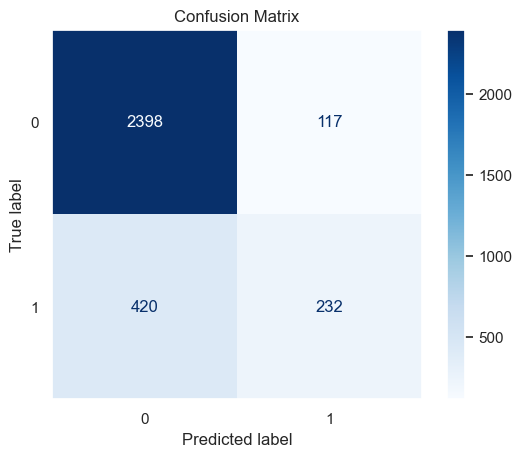

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90      2515
         1.0       0.66      0.36      0.46       652

    accuracy                           0.83      3167
   macro avg       0.76      0.65      0.68      3167
weighted avg       0.81      0.83      0.81      3167



In [193]:
print('Logistic Regression Model Evaluation')
evaluating(y_pred_lgr_nna_2,y_test_nna) 

The accuracy rate is only 0.83, with a very low recall rate, suggesting that this model is not strong enough.   
Polynomial features with a degree of 2 were created below to explore the possibility of a 'polynomial correlation,' but unfortunately, the Pearson correlation still appears too weak.

In [194]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_nna[num_col])
risk_poly = pd.DataFrame(X_poly, columns = poly.get_feature_names_out())
(risk_poly.join(risk_nna[['Current_loan_status_encoded']]).corr()[['Current_loan_status_encoded']]
        .sort_values(by='Current_loan_status_encoded').reset_index()).head(5)

,index,Current_loan_status_encoded
0,customer_income,-0.161217
1,customer_age customer_income,-0.124475
2,customer_income employment_duration,-0.116687
3,customer_income term_years,-0.103249
4,employment_duration,-0.089498


---
### The choice of encoder and handling of missing values and model performance

I have always believed that filling in missing values with the closest approximation to reality is the best approach, as it respects the integrity of the data. However, after encountering the WOE encoder, I realized that it's not always necessary to handle missing values in this way. Even with a random forest model, missing values can be treated as their **own category**, and leaving them as missing may actually be the closest representation of reality. 

This is particularly relevant in cases like `historical_default`, where 65% of the values are missing. With such a large proportion, the decision to fill or leave them can significantly impact the model. This experience will always remind me to explore different approaches when dealing with a substantial amount of missing data. On the other hand, however, dropping missing values (10%) in `employment_duration` is better than WOE them. There are more to be explored. 

---
### Meaning of false positive and false negative

**False positive prediction**: decline the loan applications of the customers not default -> if this is the main business of the bank, the revenue will be lowered

**False negative prediction**: accept the loan applications of the customers that would default -> bank will also lose money, but other parameters needs to be considered, for example, loss given rate(LGD), exposure at default etc. It would also miscalculate the security deposit the bank needs to prepare. However, this effect should be marginal as here we are dealing with the loans to individual instead of to company. 

My financial knowledge is very limited, so this is the best that I can provide. 

---
### Imbalanced target

It is evident that in the `risk` dataset, `DEFALT` and `NO DEFALT` proportion is very imbalanced (2:8). This can lead to difficulty in terms of model improvement.

Following ways are proposed to mitigate this issue:
1. Increase number of `NO DEFAULT` by doubling those instances
2. Decrease number of `DEFAULT` based on some features - i.e. `loan_intent`, `cluster` after clustering...

These are not tested due to the time restrain, but can be explored in the future.